## Lecture 4 — Data (BCRP + Yahoo) + Plots + Stats + VaR 

Reproduce the key parts of the lecture notebook using:

- **Peru (BCRP API)**: `PD04637PD`, `PD04639PD`, `PD04704XD`, `PD04701XD`  
  *(FX + commodities exactly as in the notebook)*
- **USA (yfinance)**: `SPY`, `TLT`, `GLD`

**Deliverables**
- Multiple **plots** (including **one with annotations**)  
- A **summary statistics table**  
- **Historical 95% VaR** for a **60/40 portfolio** (SPY/TLT)

In [12]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# For fetching real financial data
import yfinance as yf

# Date handling
from datetime import datetime, timedelta

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("All libraries imported successfully!")

All libraries imported successfully!


In [13]:
# Define the stocks we want to analyze
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
ticker_names = {
    'AAPL': 'Apple',
    'MSFT': 'Microsoft',
    'GOOGL': 'Google',
    'JPM': 'JPMorgan',
    'GS': 'Goldman Sachs'
}

# Set date range (last 2 years)
end_date = datetime.now()
start_date = end_date - timedelta(days=730)

# Download stock data
print("Downloading stock data...")
stock_data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Handle MultiIndex columns from yfinance
# yfinance returns MultiIndex columns: (Price, Ticker)
if isinstance(stock_data.columns, pd.MultiIndex):
    # Get close prices (yfinance no longer provides Adj Close by default)
    prices = stock_data['Close'].copy()
    volume = stock_data['Volume'].copy()
else:
    # Single ticker case
    prices = stock_data[['Close']].copy()
    prices.columns = [tickers[0]]
    volume = stock_data[['Volume']].copy()
    volume.columns = [tickers[0]]

# Rename columns to company names
prices.columns = [ticker_names.get(col, col) for col in prices.columns]
volume.columns = [ticker_names.get(col, col) for col in volume.columns]

In [14]:
from pathlib import Path
import hashlib
import re
import warnings

import numpy as np
import pandas as pd

# ── Configuración general ──
CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)
warnings.filterwarnings("ignore")

# ── Helpers ──
_ES_TO_EN_MONTH = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec"
}

def _hash_key(*parts: str) -> str:
    h = hashlib.sha256()
    for p in parts:
        h.update(str(p).encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:24]

def _normalize_period(code: str, period: str | None) -> str | None:
    if period is None:
        return None
    period = str(period).strip()
    freq = code[-2:].upper() if len(code) >= 2 else ""

    if freq in ["PD", "PM", "MD"]:
        if re.fullmatch(r"\d{4}-\d{1,2}", period):
            y, m = period.split("-")
            return f"{int(y):04d}-{int(m):02d}-01"
        if re.fullmatch(r"\d{4}", period):
            return f"{int(period):04d}-01-01"
        return period
    return period

def _parse_bcrp_period_name(name: str) -> pd.Timestamp:
    s = str(name).strip()
    # ISO-ish
    try:
        if re.fullmatch(r"\d{4}(-\d{1,2}){0,2}", s):
            return pd.to_datetime(s, errors="raise")
    except Exception:
        pass
    # Monthly like "Mar.2020"
    m = re.fullmatch(r"([A-Za-zÁÉÍÓÚÑñ]{3})\.(\d{4})", s)
    if m:
        mon_es, y = m.groups()
        mon = _ES_TO_EN_MONTH.get(mon_es[:3], mon_es[:3])
        return pd.to_datetime(f"{mon}.{y}", format="%b.%Y", errors="coerce")
    # Daily like "18Nov25"
    m = re.fullmatch(r"(\d{2})([A-Za-zÁÉÍÓÚÑñ]{3})(\d{2})", s)
    if m:
        d, mon_es, yy = m.groups()
        mon = _ES_TO_EN_MONTH.get(mon_es[:3], mon_es[:3])
        year = 2000 + int(yy) if int(yy) <= 69 else 1900 + int(yy)
        return pd.to_datetime(f"{d}{mon}{year}", format="%d%b%Y", errors="coerce")
    return pd.to_datetime(s, errors="coerce")

# ── Función principal para obtener series BCRP ──
def bcrp_get(series_codes, start: str | None = None, end: str | None = None, lang: str = "esp") -> pd.DataFrame:
    import requests

    if isinstance(series_codes, (list, tuple)):
        codes_list = [str(c).strip() for c in series_codes]
        codes = "-".join(codes_list)
        freq_code = codes_list[0]
    else:
        codes = str(series_codes).strip()
        codes_list = codes.split("-")
        freq_code = codes_list[0]

    start_n = _normalize_period(freq_code, start)
    end_n = _normalize_period(freq_code, end)

    key = _hash_key("bcrp", codes, start_n or "", end_n or "", lang)
    cache_path = CACHE_DIR / f"bcrp_{key}.pkl"
    if cache_path.exists():
        return pd.read_pickle(cache_path)

    base_url = "https://estadisticas.bcrp.gob.pe/estadisticas/series/api"
    parts = [base_url, codes, "json"]
    if start_n and end_n:
        parts += [start_n, end_n]
    if lang:
        parts += [lang]
    url = "/".join(parts)

    r = requests.get(url, timeout=30)
    r.raise_for_status()
    obj = r.json()

    periods = obj.get("periods", [])
    rows = []
    for p in periods:
        name = p.get("name")
        vals = p.get("values", [])
        if isinstance(vals, str):
            vals = [vals]
        if name is None or not isinstance(vals, list):
            continue
        vals = (vals + [None] * len(codes_list))[:len(codes_list)]
        rows.append([name] + vals)

    df = pd.DataFrame(rows, columns=["date"] + codes_list)
    if df.shape[0] == 0:
        return pd.DataFrame(columns=["date"] + codes_list)

    df["date"] = df["date"].apply(_parse_bcrp_period_name)
    for c in codes_list:
        df[c] = df[c].replace({"n.d.": np.nan, "nd": np.nan, "N.D.": np.nan})
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
    df.to_pickle(cache_path)
    return df

def bcrp_get_cached_or_empty(series_codes, start: str, end: str) -> pd.DataFrame:
    try:
        return bcrp_get(series_codes, start=start, end=end)
    except Exception:
        if isinstance(series_codes, (list, tuple)):
            codes_list = [str(c).strip() for c in series_codes]
        else:
            codes_list = [str(series_codes).strip()]
        return pd.DataFrame(columns=["date"] + codes_list)

1. Build (and display) the **BCRPData API URL** that requests the 4 series used in the notebook.  


In [15]:
series_bcrp = ["PD04637PD","PD04639PD","PD04704XD","PD04701XD"]

df_bcrp = bcrp_get(series_codes=series_bcrp,start="2015-01-01",end="2024-12-31",lang="esp")

df_bcrp.head()

,date,PD04637PD,PD04639PD,PD04704XD,PD04701XD
0,2015-02-02,3.06,3.06,251.09,1272.50
1,2015-02-03,3.06,3.06,258.32,1264.25
2,2015-02-04,3.06,3.06,258.91,1268.50
3,2015-02-05,3.06,3.06,253.78,1259.25
4,2015-02-06,3.07,3.06,258.18,1241.00


2. Download those series and build a **tidy** table: `date`, `series`, `value`.  


In [16]:
df_tidy = (df_bcrp.melt(id_vars="date",var_name="series",value_name="value")
          .dropna(subset=["value"]).sort_values(["series", "date"]).reset_index(drop=True))

df_tidy.head(10)

,date,series,value
0,2015-02-02,PD04637PD,3.06
1,2015-02-03,PD04637PD,3.06
2,2015-02-04,PD04637PD,3.06
3,2015-02-05,PD04637PD,3.06
4,2015-02-06,PD04637PD,3.07
5,2015-02-09,PD04637PD,3.06
6,2015-02-10,PD04637PD,3.07
7,2015-02-11,PD04637PD,3.09
8,2015-02-12,PD04637PD,3.08
9,2015-02-13,PD04637PD,3.07


3. Clean to **wide format** with columns: `fx_interbank`, `fx_sbs`, `gold`, `copper` (as in the notebook).  


In [20]:
series_map = {
    "PD04637PD": "fx_interbank",
    "PD04639PD": "fx_sbs",
    "PD04704XD": "copper",
    "PD04701XD": "gold",
}

df_wide = (
    df_tidy
        .loc[df_tidy["series"].isin(series_map)]
        .assign(series=lambda x: x["series"].map(series_map))
        .pivot(index="date", columns="series", values="value")
        .sort_index()
        .reset_index()
)

print(df_wide)

series       date  copper  fx_interbank  fx_sbs    gold
0      2015-02-02  251.09          3.06    3.06 1272.50
1      2015-02-03  258.32          3.06    3.06 1264.25
2      2015-02-04  258.91          3.06    3.06 1268.50
3      2015-02-05  253.78          3.06    3.06 1259.25
4      2015-02-06  258.18          3.07    3.06 1241.00
...           ...     ...           ...     ...     ...
1514   2024-11-25  404.51          3.77    3.77 2625.01
1515   2024-11-26  404.83          3.77    3.77 2633.15
1516   2024-11-27  403.58          3.75    3.75 2636.02
1517   2024-11-28  401.45          3.75    3.74 2637.92
1518   2024-11-29  402.74          3.74    3.74 2643.15

[1519 rows x 5 columns]


4. Download `SPY`, `TLT`, `GLD` from yfinance and build: `date`, `ticker`, `close`.  


In [21]:
START = "2021-01-01"
END = "2025-12-18"

tickers = ["SPY", "TLT", "GLD"]

prices = yf.download(tickers,start=START,end=END,auto_adjust=True,progress=False)

df_tidy = (prices["Close"].reset_index().melt(id_vars="Date",
                                              var_name="ticker",
                                              value_name="close").rename(columns={"Date": "date"})
                                                                 .dropna(subset=["close"])
                                                                 .sort_values(["ticker", "date"])
                                                                 .reset_index(drop=True))

df_tidy.head(10)

,date,ticker,close
0,2021-01-04,GLD,182.33
1,2021-01-05,GLD,182.87
2,2021-01-06,GLD,179.90
3,2021-01-07,GLD,179.48
4,2021-01-08,GLD,173.34
5,2021-01-11,GLD,173.00
6,2021-01-12,GLD,174.12
7,2021-01-13,GLD,173.37
8,2021-01-14,GLD,173.28
9,2021-01-15,GLD,171.13


5. Compute **daily returns** by ticker (`ret`) and validate there are **no inf values**.  


In [22]:
df_ret = (
    df_tidy
    .sort_values(["ticker", "date"])
    .assign(
        ret=lambda x: x.groupby("ticker")["close"].pct_change()
    )
)

import numpy as np

df_ret["ret"] = df_ret["ret"].replace([np.inf, -np.inf], np.nan)
df_ret = df_ret.dropna(subset=["ret"])

assert not np.isinf(df_ret["ret"]).any(), "There are inf values in returns"

df_ret.head()

,date,ticker,close,ret
1,2021-01-05,GLD,182.87,0.00
2,2021-01-06,GLD,179.90,-0.02
3,2021-01-07,GLD,179.48,-0.00
4,2021-01-08,GLD,173.34,-0.03
5,2021-01-11,GLD,173.00,-0.00


6. *(Quantities)* Compare FX levels in Peru: produce a **plot** and a short comment.  


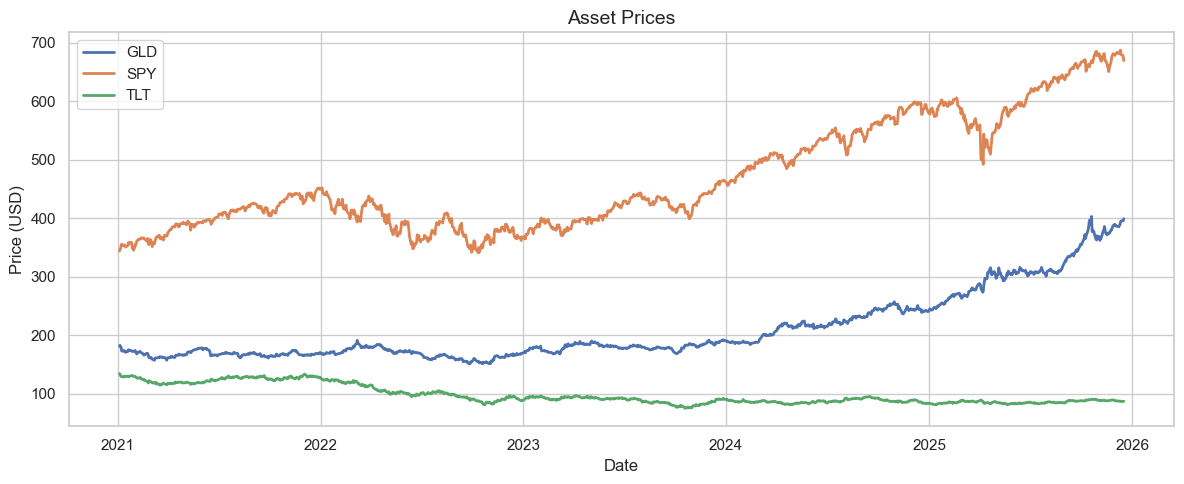

In [23]:
# Ensure datetime
df_tidy["date"] = pd.to_datetime(df_tidy["date"])

# Style
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 5))

# Plot each ticker
for ticker, g in df_tidy.groupby("ticker"):
    ax.plot(g["date"], g["close"], label=ticker, linewidth=2)

# Title and labels
ax.set_title("Asset Prices", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")

# Date formatting
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=0)

# Legend
ax.legend()

plt.tight_layout()
plt.show()

7. *(Proportions)* Compute the **share of positive-return days** by ticker (USA).  


In [24]:
# Crear columna booleana: True si retorno > 0
df_ret["positive"] = df_ret["ret"] > 0

positive_share = (
    df_ret
    .groupby("ticker")["positive"]
    .mean()  # La media de True/False = proporción
    .reset_index()
    .rename(columns={"positive": "share_positive_days"})
)

positive_share

,ticker,share_positive_days
0,GLD,0.54
1,SPY,0.55
2,TLT,0.49


8. Plot that share as a **bar chart** and add **labels above each bar** (`annotate`).  


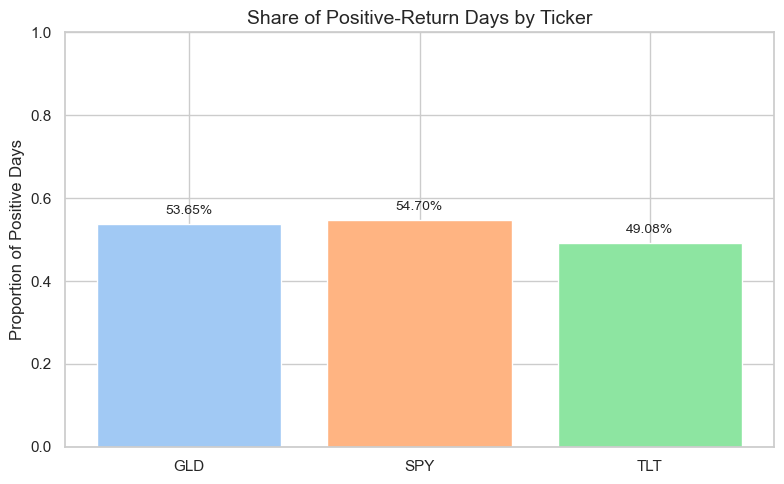

In [25]:
# Estilo seaborn
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 5))

# Bar chart
bars = ax.bar(
    positive_share["ticker"],
    positive_share["share_positive_days"],
    color=sns.color_palette("pastel", len(positive_share))
)

# Etiquetas arriba de cada barra
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f'{height:.2%}',           # Formato porcentaje
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),             # 5 puntos vertical offset
        textcoords="offset points",
        ha='center',
        va='bottom',
        fontsize=10
    )

# Título y etiquetas
ax.set_title("Share of Positive-Return Days by Ticker", fontsize=14)
ax.set_ylabel("Proportion of Positive Days")
ax.set_ylim(0, 1)  # asegurar que y esté entre 0 y 1

plt.tight_layout()
plt.show()

9. *(Distributions)* Compare the distribution of **Peru Gold** vs **GLD** (histogram).  


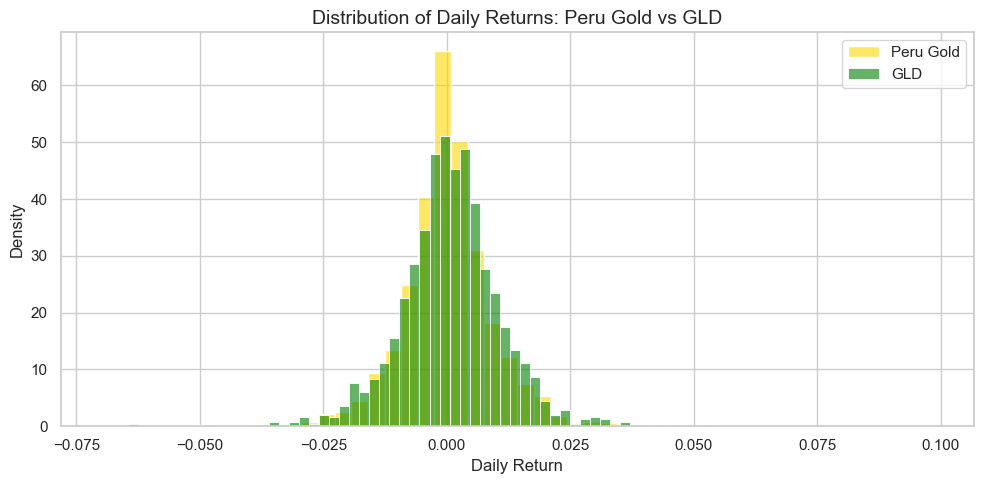

In [26]:
# Peru Gold daily returns
gold_ret = df_wide["gold"].pct_change().dropna()

# GLD daily returns
gld_ret = df_ret[df_ret["ticker"]=="GLD"]["ret"].dropna()

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 5))

# Histograma Peru Gold
sns.histplot(gold_ret, bins=50, color="gold", label="Peru Gold", alpha=0.6, stat="density", ax=ax)

# Histograma GLD
sns.histplot(gld_ret, bins=50, color="green", label="GLD", alpha=0.6, stat="density", ax=ax)

# Título y etiquetas
ax.set_title("Distribution of Daily Returns: Peru Gold vs GLD", fontsize=14)
ax.set_xlabel("Daily Return")
ax.set_ylabel("Density")

# Leyenda
ax.legend()

plt.tight_layout()
plt.show()

10. Add an **ECDF** (if used in the notebook) and comment on what changes vs the histogram.  


11. *(Relationships)* Build `FX_change` and relate it to `SPY_ret` (scatter plot).  


12. Compute the **correlation** between `FX_change` and `SPY_ret` and explain the sign.  


13. Estimate a simple regression `FX_change ~ SPY_ret` and interpret the coefficient.  


14. *(Pandas)* Do a selection exercise: `.iloc` (position-based) vs conditional filtering.  


15. Create missing data on purpose in one series and apply imputation (as in the notebook).  


16. Standardize a variable (z-score) and plot **before vs after**.  


17. Find the day with the largest `|SPY_ret|` and **annotate it** in the returns plot (like the exercise).  


18. Save one figure into `/figures` using `savefig` and verify the file exists.  


19. Build a **summary stats table** for returns (mean, sd, p5, p95, etc.).  


20. Compute **historical 95% VaR** for a **60/40 portfolio (SPY/TLT)** and explain what it means.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)

In [3]:
from __future__ import annotations

from pathlib import Path
import hashlib
import re
from io import StringIO

import numpy as np
import pandas as pd

# Configuration


CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)

# Cache utilities (parquet -> csv fallback)

def _hash_key(*parts: object) -> str:
    h = hashlib.sha256()
    for p in parts:
        h.update(str(p).encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:24]

def _cache_paths(prefix: str, key: str) -> tuple[Path, Path]:
    p_parquet = CACHE_DIR / f"{prefix}_{key}.parquet"
    p_csv = CACHE_DIR / f"{prefix}_{key}.csv"
    return p_parquet, p_csv

def _read_cache_df(prefix: str, key: str) -> pd.DataFrame | None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    if p_parquet.exists():
        try:
            return pd.read_parquet(p_parquet)
        except Exception:
            pass
    if p_csv.exists():
        try:
            return pd.read_csv(p_csv)
        except Exception:
            pass
    return None

def _write_cache_df(df: pd.DataFrame, prefix: str, key: str) -> None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    try:
        df.to_parquet(p_parquet, index=False)
        return
    except Exception:
        pass
    try:
        df.to_csv(p_csv, index=False)
    except Exception:
        # If caching fails, ignore silently (no exceptions)
        return

# HTTP helpers

def http_get_text(url: str, timeout: int = 30, headers: dict | None = None) -> str:
    """
    Returns response text. Raises inside, but callers wrap in try/except (no exceptions to user).
    """
    import requests

    h = {
        "User-Agent": "Mozilla/5.0 (compatible; FinanceCourse/1.0)",
        "Accept": "*/*",
    }
    if headers:
        h.update(headers)

    r = requests.get(url, timeout=timeout, headers=h)
    r.raise_for_status()
    return r.text
# Numeric + returns helpers
def parse_number(x) -> float:
    """
    Robust number parser:
      - '3,367' -> 3.367 (comma decimal)
      - '1,234.56' -> 1234.56 (comma thousands)
    """
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return np.nan

    if "," in s and "." in s:
        s = s.replace(",", "")
    elif "," in s and "." not in s:
        s = s.replace(",", ".")

    try:
        return float(s)
    except Exception:
        return np.nan

def pct_change(s: pd.Series) -> pd.Series:
    x = pd.to_numeric(s, errors="coerce")
    return x.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)
# BCRP parsing

_SP2EN = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec",
}

def _clean_bcrp_payload(txt: str) -> str:
    """
    BCRP sometimes returns "CSV" wrapped as HTML with <br> line breaks.
    Normalize to plain text with real newlines.
    """
    x = txt.replace("\r\n", "\n").replace("\r", "\n")
    x = x.replace("<br/>", "\n").replace("<br />", "\n").replace("<br>", "\n")
    x = re.sub(r"</?pre[^>]*>", "", x, flags=re.IGNORECASE)
    return x.strip()

def _detect_sep(header_line: str) -> str:
    return ";" if header_line.count(";") > header_line.count(",") else ","

def _parse_bcrp_date(s: pd.Series) -> pd.Series:
    """
    Parses common BCRP date formats:
      - Daily: 2022-01-03, 03Jan22, 03Ene22
      - Monthly: Jan22, Ene22, 2022-1, 2022-01
      - Yearly: 2022
    """
    x = s.astype(str).str.strip()
    x = x.str.replace(".", "", regex=False)

    y = x
    for k, v in _SP2EN.items():
        y = y.str.replace(k, v, regex=False)

    dt = pd.to_datetime(y, format="%Y-%m-%d", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%d%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y-%m", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], errors="coerce")

    return dt


def bcrp_series_csv(
    series_codes: list[str],
    start: str,
    end: str,
    lang: str = "ing",
) -> pd.DataFrame:
    """
    BCRPData API (CSV):
      https://estadisticas.bcrp.gob.pe/estadisticas/series/api/[codes]/csv/[start]/[end]/[lang]

    Returns LONG DataFrame:
      date, series_name, value

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    codes = "-".join(series_codes)
    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{start}/{end}/{lang}"

    key = _hash_key("bcrp", url)
    cached = _read_cache_df("bcrp", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        txt = http_get_text(url, timeout=30)
        txt = _clean_bcrp_payload(txt)

        lines = [ln for ln in txt.split("\n") if ln.strip() != ""]
        if len(lines) < 2:
            print("[BCRP] Endpoint returned no usable rows. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        sep = _detect_sep(lines[0])
        df = pd.read_csv(StringIO("\n".join(lines)), sep=sep)

        if df.shape[0] == 0 or df.shape[1] < 2:
            print("[BCRP] Returned an empty table. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        date_col = df.columns[0]
        value_cols = list(df.columns[1:])

        out = df.melt(
            id_vars=[date_col],
            value_vars=value_cols,
            var_name="series_name",
            value_name="value_raw",
        ).rename(columns={date_col: "date"})

        out["date"] = _parse_bcrp_date(out["date"])
        out["value"] = out["value_raw"].map(parse_number)

        out = out.drop(columns=["value_raw"])
        out = out.dropna(subset=["date"]).sort_values(["series_name", "date"]).reset_index(drop=True)

        _write_cache_df(out, "bcrp", key)
        return out

    except Exception as e:
        print(f"[BCRP] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "series_name", "value"])
# Yahoo Finance (yfinance)

def yfinance_download(tickers: list[str], start: str, end: str) -> pd.DataFrame:
    """
    Yahoo Finance via yfinance.
    Returns LONG DataFrame:
      date, ticker, close, volume, ret

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    try:
        import yfinance as yf
    except Exception:
        print("[yfinance] yfinance not installed/importable. Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

    key = _hash_key("yfinance", " ".join(tickers), start, end)
    cached = _read_cache_df("yf", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        data = yf.download(tickers=tickers, start=start, end=end, auto_adjust=False, progress=False)
        if data is None or data.shape[0] == 0:
            print("[yfinance] Returned no rows. Continuing...")
            return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

        frames = []
        if isinstance(data.columns, pd.MultiIndex):
            for t in tickers:
                if t not in data.columns.get_level_values(1):
                    continue
                sub = data.xs(t, axis=1, level=1).copy()
                sub = sub.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
                sub["ticker"] = t
                sub = sub.rename(columns={"Close": "close", "Volume": "volume"})
                frames.append(sub[["date", "ticker", "close", "volume"]])
            out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
        else:
            out = data.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
            out["ticker"] = tickers[0]
            out = out.rename(columns={"Close": "close", "Volume": "volume"})
            out = out[["date", "ticker", "close", "volume"]]

        out["date"] = pd.to_datetime(out["date"], errors="coerce")
        out["close"] = pd.to_numeric(out["close"], errors="coerce")
        out["volume"] = pd.to_numeric(out["volume"], errors="coerce")

        out = out.dropna(subset=["date", "close"]).sort_values(["ticker", "date"]).reset_index(drop=True)
        out["ret"] = out.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

        _write_cache_df(out, "yf", key)
        return out

    except Exception as e:
        print(f"[yfinance] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

## 1) Load real financial data

If an endpoint is temporarily unavailable, this notebook prints a short message and continues

In [4]:
START_D = "2022-01-01"
END_D   = "2025-12-18"

peru = bcrp_series_csv(
    series_codes=["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"],
    start=START_D,
    end=END_D,
    lang="ing"
)

usa = yfinance_download(["SPY", "TLT", "GLD"], start=START_D, end=END_D)

print("Peru rows:", peru.shape[0], "| USA rows:", usa.shape[0])

# show in English (wide + renamed)
peru_wide = (
    peru.pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
        .reset_index()
        .sort_values("date")
)
peru_wide.columns.name = None

rename_map = {}
for c in peru_wide.columns:
    cl = str(c).lower()
    if "interbanc" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_interbank_buy"
    elif "sbs" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_sbs_buy"
    elif "oro" in cl or "gold" in cl:
        rename_map[c] = "gold_london"
    elif "cobre" in cl or "copper" in cl:
        rename_map[c] = "copper_london"

peru_wide = peru_wide.rename(columns=rename_map)
peru_wide.head()

Peru rows: 4136 | USA rows: 2982


,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


### 1.1) Quantities

#### Exercise 1.1 — FX level comparison (Peru)

**Tasks**
1. Filter `peru` to the two FX series (Interbank buy and SBS buy).
2. Pivot to wide format (`date` as index).
3. Plot both FX levels in the same line chart.
4. Create `spread = sbs - interbank` and plot it in a separate figure.

### 1.2) Proportions

#### Exercise 1.2 — Share of positive-return days (USA)

Define a positive day as `ret > 0`.

**Tasks**
1. For each ticker in `usa`, compute the share of days with `ret > 0`.
2. Plot a bar chart of these shares.
3. Add labels (percent format) and a title.

### 1.3) Distributions

#### Exercise 1.3 — Return distributions: Peru Gold vs US Gold ETF

**Goal:** compare distributions of a **Peru gold reference price** series vs the **US gold ETF (GLD)**.

**Tasks**
1. From `peru`, build a daily gold series and compute returns.
2. From `usa`, filter to GLD returns.
3. Plot two histograms (separate figures) with the same binning.
4. Optional: overlay KDE for each distribution.

### 1.4) Relationships

#### Exercise 1.4 — FX changes vs market returns (Peru + USA)

Use:
- Peru interbank FX (daily % change)
- SPY returns (broad US market benchmark)

**Tasks**
1. Build interbank FX daily returns from the Peru FX series.
2. Build SPY daily returns from `usa`.
3. Merge on date.
4. Scatter plot (x = SPY ret, y = FX ret).
5. Compute correlation and write 2–3 sentences interpreting the sign/magnitude.

### 1.5) References 

- BCRP Statistical Series (Daily): exchange rates and commodities series catalog.
- BCRPData API (CSV endpoint) for downloading series.
- yfinance: Python wrapper that fetches historical market data from Yahoo Finance.

## 2) Online Data Sources 

### Exercise 2.1 — Inspect the BCRPData API URL (requests)
You are already downloading from BCRPData. Now you will **inspect** what is being requested.

**Tasks**
1. Recreate the API URL string used to download the Peru series.
2. Print it.
3. Download the CSV text using `http_get_text` and display the first 10 lines.
4. Explain (in a markdown cell) what each part of the URL means.

In [5]:
from pathlib import Path
import time
import requests

def fetch_text_with_session(url: str, timeout: int = 30, tries: int = 3) -> str:
    """Fetch raw text using a requests.Session (cookies) + browser-like headers."""
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        ),
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.9,es;q=0.8",
        "Referer": "https://estadisticas.bcrp.gob.pe/",
        "Connection": "keep-alive",
        "Cache-Control": "no-cache",
        "Pragma": "no-cache",
    }

    s = requests.Session()

    # Warm-up request to get cookies (can help with WAF/403)
    try:
        s.get("https://estadisticas.bcrp.gob.pe/", headers=headers, timeout=timeout)
    except Exception:
        pass

    last = None
    for k in range(tries):
        try:
            r = s.get(url, headers=headers, timeout=timeout)
            if r.status_code == 403:
                last = requests.HTTPError(f"403 Forbidden for url: {url}")
                time.sleep(1.5 * (k + 1))
                continue
            r.raise_for_status()
            return r.text
        except Exception as e:
            last = e
            time.sleep(1.5 * (k + 1))

    raise last


SERIES = ["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"]

START_D = "2022-01-01"
END_D   = "2025-12-18"
LANG    = "ing"

# 1) Recreate the API URL string used to download the Peru series
codes = "-".join(SERIES)
url_multi = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{START_D}/{END_D}/{LANG}"

print("BCRPData URL (multi-series):")
print(url_multi)

# 2-3) Try to download raw CSV text and show first 10 lines
txt = None
raw_source = None

try:
    txt = fetch_text_with_session(url_multi, timeout=30, tries=3)
    raw_source = "server (multi-series)"
except Exception as e:
    print(f"[BCRP] Multi-series request failed: {type(e).__name__}: {e}")

# Fallback: try only ONE series (often allowed even if multi is blocked)
if txt is None:
    one = SERIES[0]
    url_one = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{one}/csv/{START_D}/{END_D}/{LANG}"
    print("\nBCRPData URL (single-series fallback):")
    print(url_one)
    try:
        txt = fetch_text_with_session(url_one, timeout=30, tries=3)
        raw_source = f"server (single-series: {one})"
    except Exception as e:
        print(f"[BCRP] Single-series request failed: {type(e).__name__}: {e}")

if txt is not None:
    # Replace <br> HTML tags with newline characters (some responses use HTML breaks)
    txt_clean = (txt.replace("<br />", "\n").replace("<br/>", "\n").replace("<br>", "\n"))

    lines = txt_clean.splitlines()
    print(f"\nFirst 10 lines of the response ({raw_source}):")
    for i, line in enumerate(lines[:10], start=1):
        print(f"{i:02d}: {line}")

else:
    # Last-resort fallback: reconstruct "CSV-like" lines from your cached dataframes
    # NOTE: this is NOT the raw server response; it's reconstructed from local data.
    print("\n[BCRP] Could not fetch raw text due to 403. Reconstructing lines from local data (NOT raw server response).")

    # Try to use peru_w if it exists; else use peru if it exists.
    if "peru_w" in globals() and hasattr(peru_w, "head"):
        preview = peru_w.head(10).to_csv(index=False)
        rec_lines = preview.splitlines()[:10]
        print("\nFirst 10 lines (reconstructed from peru_w):")
        for i, line in enumerate(rec_lines, start=1):
            print(f"{i:02d}: {line}")
    elif "peru" in globals() and hasattr(peru, "head"):
        preview = peru.head(10).to_csv(index=False)
        rec_lines = preview.splitlines()[:10]
        print("\nFirst 10 lines (reconstructed from peru):")
        for i, line in enumerate(rec_lines, start=1):
            print(f"{i:02d}: {line}")
    else:
        print("No local dataframes found (peru/peru_w). Run the download cells first.")

BCRPData URL (multi-series):
https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/csv/2022-01-01/2025-12-18/ing

First 10 lines of the response (server (multi-series)):
01: D&iacute;a/Mes/A&ntilde;o,"Tipo de cambio - TC Interbancario (S/ por US$) - Compra","Tipo de cambio - TC Sistema bancario SBS (S/ por US$) - Compra","Cotizaciones internacionales - Cobre (Londres, cUS$ por libras)","Cotizaciones internacionales - Oro (Londres, US$ por onzas troy)"
02: "03.Jan.22","3.98366666666667","3.987","439.621724973844","1820.1"
03: "04.Jan.22","3.9595","3.963","438.170229389944","1811.4"
04: "05.Jan.22","3.952","3.953","443.522619355577","1826.25"
05: "06.Jan.22","3.96716666666667","3.967","433.86110187524","1789.35"
06: "07.Jan.22","3.94516666666667","3.948","436.129063725084","1792.6"
07: "10.Jan.22","3.92766666666667","3.925","438.397025574929","1794.2"
08: "11.Jan.22","3.91633333333333","3.919","438.260947863938","1806.8"
09: "12.Jan.22","3.89233

### Exercise 2.2 — Build a clean wide table (Peru finance data)
Turn long BCRP data into a clean table.

**Tasks**
1. Use `peru_w` (already wide).
2. Rename columns to short names:
   - `fx_interbank`, `fx_sbs`, `gold`, `copper`
   (Hint: inspect column names first.)
3. Create daily percentage changes for FX and commodities.
4. Drop rows where all four returns are missing.

## 3) Matplotlib: Constructing the Plot 

### Exercise 3.1 
Create a single figure with 2 subplots:
- Top: Peru FX spread (SBS - interbank)
- Bottom: USA SPY close price

**Tasks**
1. Build the Peru FX spread series from `peru_w`.
2. Build SPY close series from `usa_w`.
3. Use `plt.subplots(nrows=2, ncols=1, sharex=True)`.
4. Add titles, axis labels, and use `fig.tight_layout()`.

In [20]:
import numpy as np
import pandas as pd
import requests
import re
from io import StringIO

# ---------- helpers ----------
_SP2EN = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec",
}

def parse_number(x) -> float:
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return np.nan
    if "," in s and "." in s:
        s = s.replace(",", "")
    elif "," in s and "." not in s:
        s = s.replace(",", ".")
    try:
        return float(s)
    except Exception:
        return np.nan

def _clean_bcrp_payload(txt: str) -> str:
    x = txt.replace("\r\n", "\n").replace("\r", "\n")
    x = x.replace("<br/>", "\n").replace("<br />", "\n").replace("<br>", "\n")
    x = re.sub(r"</?pre[^>]*>", "", x, flags=re.IGNORECASE)
    return x.strip()

def _detect_sep(header_line: str) -> str:
    return ";" if header_line.count(";") > header_line.count(",") else ","

def _parse_bcrp_date(s: pd.Series) -> pd.Series:
    x = s.astype(str).str.strip().str.replace(".", "", regex=False)
    y = x
    for k, v in _SP2EN.items():
        y = y.str.replace(k, v, regex=False)

    dt = pd.to_datetime(y, format="%Y-%m-%d", errors="coerce")
    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%d%b%y", errors="coerce")
    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%b%y", errors="coerce")
    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], errors="coerce")
    return dt

def bcrp_series_csv(series_codes, start, end, lang="ing"):
    codes = "-".join(series_codes)
    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{start}/{end}/{lang}"
    r = requests.get(url, timeout=30, headers={"User-Agent":"Mozilla/5.0"})
    r.raise_for_status()
    txt = _clean_bcrp_payload(r.text)

    lines = [ln for ln in txt.split("\n") if ln.strip() != ""]
    sep = _detect_sep(lines[0])
    df = pd.read_csv(StringIO("\n".join(lines)), sep=sep)

    date_col = df.columns[0]
    value_cols = list(df.columns[1:])

    out = df.melt(
        id_vars=[date_col],
        value_vars=value_cols,
        var_name="series_name",
        value_name="value_raw",
    ).rename(columns={date_col: "date"})

    out["date"] = _parse_bcrp_date(out["date"])
    out["value"] = out["value_raw"].map(parse_number)
    out = out.drop(columns=["value_raw"]).dropna(subset=["date"]).sort_values(["series_name","date"]).reset_index(drop=True)
    return out

# ---------- download Peru data ----------
START_D = "2022-01-01"
END_D   = "2025-12-18"

peru = bcrp_series_csv(
    series_codes=["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"],
    start=START_D,
    end=END_D,
    lang="ing"
)

# ---------- make wide + rename ----------
peru_wide = (
    peru.pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
        .reset_index()
        .sort_values("date")
)
peru_wide.columns.name = None

rename_map = {}
for c in peru_wide.columns:
    cl = str(c).lower()
    if "interbanc" in cl and ("compra" in cl or "buy" in cl):
        rename_map[c] = "fx_interbank_buy"
    elif "sbs" in cl and ("compra" in cl or "buy" in cl):
        rename_map[c] = "fx_sbs_buy"
    elif "oro" in cl or "gold" in cl:
        rename_map[c] = "gold_london"
    elif "cobre" in cl or "copper" in cl:
        rename_map[c] = "copper_london"

peru_wide = peru_wide.rename(columns=rename_map)

print("OK - peru rows:", peru.shape[0])
print("Columns:", list(peru_wide.columns))
peru_wide.head()


OK - peru rows: 4136
Columns: ['date', 'copper_london', 'gold_london', 'fx_interbank_buy', 'fx_sbs_buy']


,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


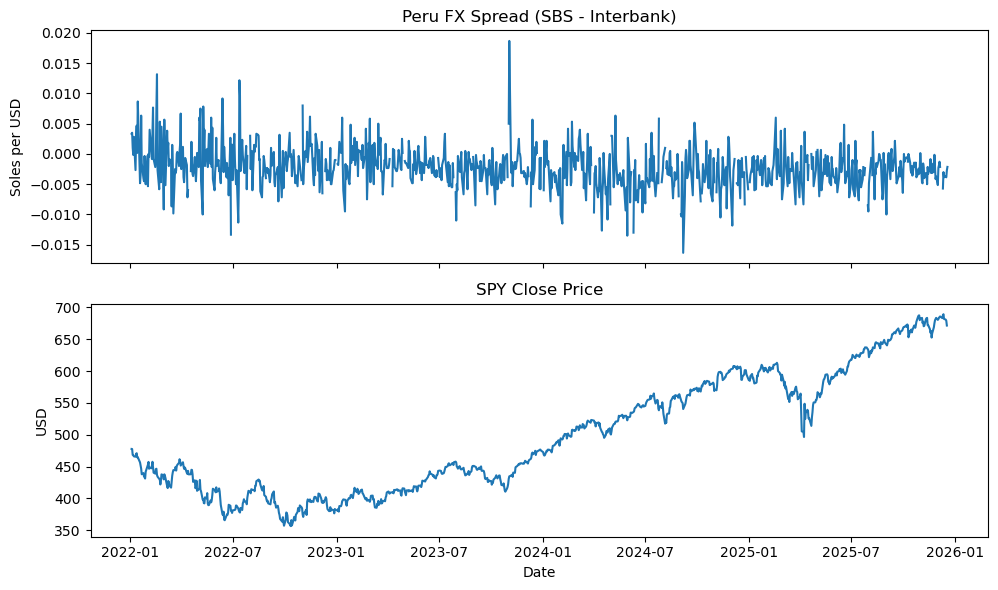

In [21]:
import matplotlib.pyplot as plt

# Spread Peru
peru_fx = peru_wide[["date","fx_sbs_buy","fx_interbank_buy"]].copy()
peru_fx["fx_spread"] = peru_fx["fx_sbs_buy"] - peru_fx["fx_interbank_buy"]

# SPY close (usa debe existir)
spy_close = (
    usa.loc[usa["ticker"]=="SPY", ["date","close"]]
       .dropna()
       .sort_values("date")
)

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,6))

axes[0].plot(peru_fx["date"], peru_fx["fx_spread"])
axes[0].set_title("Peru FX Spread (SBS - Interbank)")
axes[0].set_ylabel("Soles per USD")

axes[1].plot(spy_close["date"], spy_close["close"])
axes[1].set_title("SPY Close Price")
axes[1].set_ylabel("USD")
axes[1].set_xlabel("Date")

fig.tight_layout()
plt.show()


### Exercise 3.2 — Annotations (mark a key event on a series)
Annotate the largest absolute daily SPY return.

**Tasks**
1. Find the date with the largest `abs(ret)` for SPY.
2. Plot SPY returns over time.
3. Add an annotation at the extreme point (arrow + text).

In [22]:
import yfinance as yf
import pandas as pd

START_D = "2022-01-01"
END_D   = "2025-12-18"

# Download data
data = yf.download(
    ["SPY", "TLT", "GLD"],
    start=START_D,
    end=END_D,
    auto_adjust=False,
    progress=False
)

frames = []
for t in ["SPY", "TLT", "GLD"]:
    sub = data.xs(t, axis=1, level=1).reset_index()
    sub["ticker"] = t
    sub = sub.rename(columns={"Date": "date", "Close": "close", "Volume": "volume"})
    frames.append(sub[["date", "ticker", "close", "volume"]])

usa = (
    pd.concat(frames, ignore_index=True)
      .sort_values(["ticker", "date"])
      .reset_index(drop=True)
)

# Compute returns
usa["ret"] = usa.groupby("ticker")["close"].pct_change(fill_method=None)

print("OK - usa created")
usa.head()


OK - usa created


Price,date,ticker,close,volume,ret
0,2022-01-03,GLD,168.330002,9014400,NaN
1,2022-01-04,GLD,169.570007,6965600,0.007367
2,2022-01-05,GLD,169.059998,8715600,-0.003008
3,2022-01-06,GLD,166.990005,10902700,-0.012244
4,2022-01-07,GLD,167.750000,8191900,0.004551


Largest |SPY return|
Date: 2025-04-09 00:00:00
Return: 0.10501930183911301


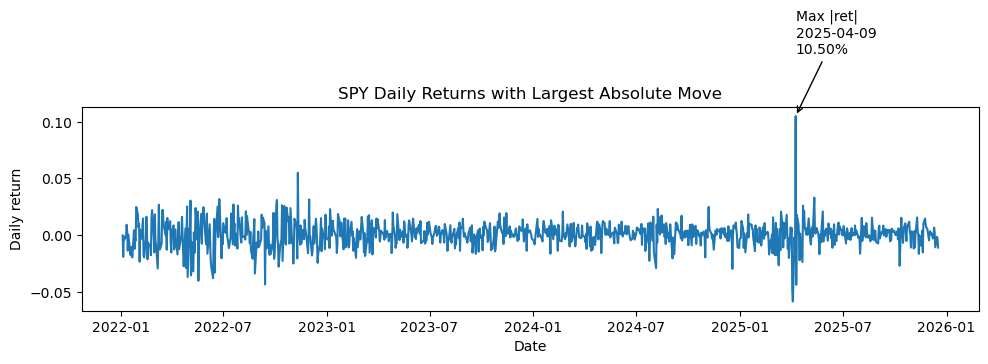

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Filter SPY returns
spy_ret = (
    usa.loc[usa["ticker"] == "SPY", ["date", "ret"]]
       .dropna()
       .sort_values("date")
       .reset_index(drop=True)
)

# 2) Find date with largest absolute return
idx_ext = spy_ret["ret"].abs().idxmax()
ext_date = spy_ret.loc[idx_ext, "date"]
ext_ret  = spy_ret.loc[idx_ext, "ret"]

print("Largest |SPY return|")
print("Date:", ext_date)
print("Return:", ext_ret)

# 3) Plot SPY returns
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(spy_ret["date"], spy_ret["ret"])
ax.set_title("SPY Daily Returns with Largest Absolute Move")
ax.set_xlabel("Date")
ax.set_ylabel("Daily return")

# 4) Annotation
ax.annotate(
    f"Max |ret|\n{ext_date.date()}\n{ext_ret:.2%}",
    xy=(ext_date, ext_ret),
    xytext=(ext_date, ext_ret * 1.5),
    arrowprops=dict(arrowstyle="->"),
    ha="left",
    va="bottom"
)

fig.tight_layout()
plt.show()


### Exercise 3.3 — Saving the figure
Save one of your figures to disk.

**Tasks**
1. Create a folder `figures/` if it does not exist.
2. Save the subplot figure as `figures/lecture4II_fx_spy.png` with dpi=150.
3. Confirm the file exists.

In [24]:
from pathlib import Path

# 1) Create folder 'figures/' if it does not exist
figures_dir = Path("figures")
figures_dir.mkdir(exist_ok=True)

# 2) Save the figure
file_path = figures_dir / "lecture4II_fx_spy.png"
fig.savefig(file_path, dpi=150)

# 3) Confirm the file exists
file_path.exists()


True

## 4) Statistics 
### Exercise 4.1 — Summary statistics table (returns)
Build a clean table of return moments.

**Tasks**
1. Create a wide daily returns table for SPY, TLT, GLD.
2. Compute: mean, std, skewness, kurtosis.
3. Present results as a DataFrame with tickers as rows.

### Exercise 4.2 — 
Run a simple regression of GLD returns on SPY returns:

\[
GLD_t = \alpha + \beta\,SPY_t + \varepsilon_t
\]

**Tasks**
1. Build aligned return vectors (drop missing).
2. Compute \alpha and \beta using the closed-form OLS formulas.
3. Plot the scatter and fitted line.
4. Interpret \beta in 2–3 sentences.

## 5) Risk and Uncertainty 

### Exercise 5.1 — Historical VaR (95%) for a 60/40 portfolio
Portfolio:
- 60% SPY
- 40% TLT

**Tasks**
1. Create a wide returns table for SPY and TLT.
2. Compute portfolio daily returns.
3. Compute 1-day 95% Historical VaR (the 5th percentile of returns).
4. Compute 1-day 95% CVaR (average return below the 5th percentile).

## 6) References

- BCRPData API (CSV endpoint): BCRP statistical series API for downloading time series
- BCRP series catalog: codes for FX (interbank/SBS) and commodity reference prices
- yfinance: Python wrapper to access historical market data from Yahoo Finance